# Hidden Line / Surface

## Bibliotheken

### Standard

In [1]:
import numpy as np

In [2]:
import numpy.linalg as la

In [3]:
import matplotlib.pyplot as pl

### Lineare Algebra

In [4]:
#Vekttorprodukt / Kreuzprodukt -> Resultierender Vektor = Rechtwinklig
def Cross (u, v):
    return np.array ([
        [u [1, 0] * v [2, 0] - u [2, 0] * v [1, 0]],
        [u [2, 0] * v [0, 0] - u [0, 0] * v [2, 0]],
        [u [0, 0] * v [1, 0] - u [1, 0] * v [0, 0]]
    ])

In [5]:
def Dot (v, w):
    return v [0, 0] * w [0, 0] + v [1, 0] * w [1, 0] + v [2, 0] * w [2, 0]

In [6]:
def Norm (v):
    return np.sqrt (Dot (v, v))

In [7]:
def Normalized (v):
    n = Norm (v)
    if n == 0:
        return v
    return v / n

In [8]:
def RotX (phi):
    t = phi * np.pi / 180
    c = np.cos (t)
    s = np.sin (t)
    return np.array ([
        [1, 0,  0],
        [0, c, -s],
        [0, s,  c]
    ])

In [9]:
def RotY (phi):
    t = phi * np.pi / 180
    c = np.cos (t)
    s = np.sin (t)
    return np.array ([
        [ c, 0, s],
        [ 0, 1, 0],
        [-s, 0, c]
    ])

In [10]:
def RotZ (phi):
    t = phi * np.pi / 180
    c = np.cos (t)
    s = np.sin (t)
    return np.array ([
        [c, -s, 0],
        [s,  c, 0],
        [0,  0, 1]
    ])

In [11]:
def Vec (*v):
    a = np.array (v)
    return a.reshape (-1, 1)

### Zeichnen

In [30]:
def Cat (*p):
    return np.concatenate (p, axis = 1)

In [31]:
def Curve (*p):
    q = Cat (*p)
    pl.plot (q [0], q [1])

In [32]:
def Iso ():
    pl.axis ('scaled')

## Definition verschiedener Flächen

### Transformation

In [17]:
Trf = RotZ (-30) @ RotX (30)

### Grid

In [20]:
def Grid (trf, func, umin, umax, unum, vmin, vmax, vnum):
    u = np.linspace (umin, umax, unum)
    v = np.linspace (vmin, vmax, vnum)
    uu, vv = np.meshgrid (u, v)
    pp = func (uu, vv)
    qq = np.tensordot (trf, pp, axes = 1)
    return qq

### Ellipsoid

In [21]:
def Ellipsoid ():

    def f (u, v):
        cu = np.cos (u); su = np.sin (u)
        cv = np.cos (v); sv = np.sin (v)
        x = 3.0 * cu * sv
        y = 2.5 * su * sv
        z = 2.0 * cv
        f = np.stack ((x, y, z), axis = 0)
        return f

    return Grid (Trf, f, 0, 2 * np.pi, 21, 0, np.pi, 11)

In [22]:
EG = Ellipsoid()

### Katenoid

In [23]:
def Katenoid ():

    def f (u, v):
        r = np.cosh (v)
        x = r * np.cos (u)
        y = r * np.sin (u)
        f = np.stack ((x, y, v), axis = 0)
        return f

    return Grid (Trf, f, 0, 2 * np.pi, 21, 1.5, -1.5, 11)

In [24]:
KG = Katenoid()

## Wireframe ohne verdeckte Linien

In [25]:
def GridWire (p):

    def Curve (*p):
        q = Cat (*p)
        pl.plot (q [0], q [1], color = 'black', linewidth = 0.3)

    for i in range (p.shape [1]):
        Curve (p [:, i, :])
    for k in range (p.shape [2]):
        Curve (p [:, :, k])

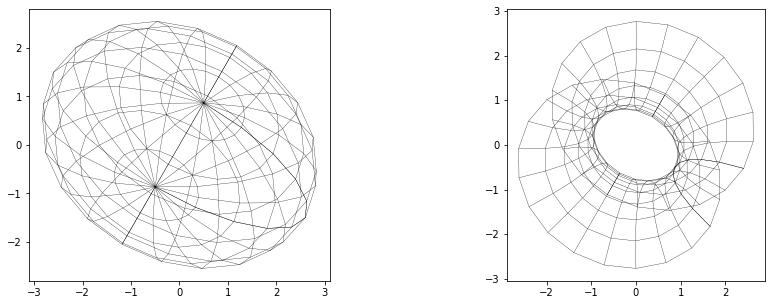

In [22]:
pl.figure (figsize = (15, 5))
pl.subplot (1, 2, 1); GridWire (EG); Iso();
pl.subplot (1, 2, 2); GridWire (KG); Iso();

## Dreiecke ohne verdeckte Linien

In [33]:
def Tri (grid):
    #Anzahl der Maschen -> Anzahl Punkte -1
    inum = grid.shape [1] - 1
    jnum = grid.shape [2] - 1
    tri = np.zeros ((9, inum * jnum * 2)); k = 0
    for i0 in range (inum):
        i1 = i0 + 1
        for j0 in range (jnum):
            j1 = j0 + 1
            a = grid [:, i0, j0]
            b = grid [:, i1, j0]
            c = grid [:, i1, j1]
            d = grid [:, i0, j1]
            tri [0:3, k] = a; tri [3:6, k] = b; tri [6:9, k] = c; k += 1
            tri [0:3, k] = c; tri [3:6, k] = d; tri [6:9, k] = a; k += 1
    return tri

In [34]:
ET = Tri (EG)
KT = Tri (KG)

In [35]:
def TriWire (tri):
    for i in range (tri.shape [1]):
        a = tri [0:3, i] .reshape (-1, 1)
        b = tri [3:6, i] .reshape (-1, 1)
        c = tri [6:9, i] .reshape (-1, 1)
        p = Cat (a, b, c, a)
        pl.plot (p [0], p [1], color = 'black', linewidth = 0.3)

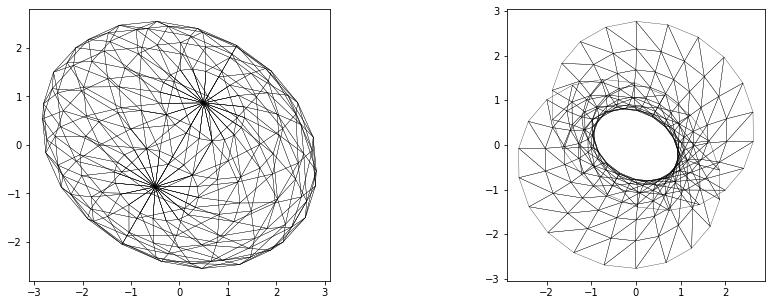

In [36]:
pl.figure (figsize = (15, 5))
pl.subplot (1, 2, 1); TriWire (ET); Iso();
pl.subplot (1, 2, 2); TriWire (KT); Iso();

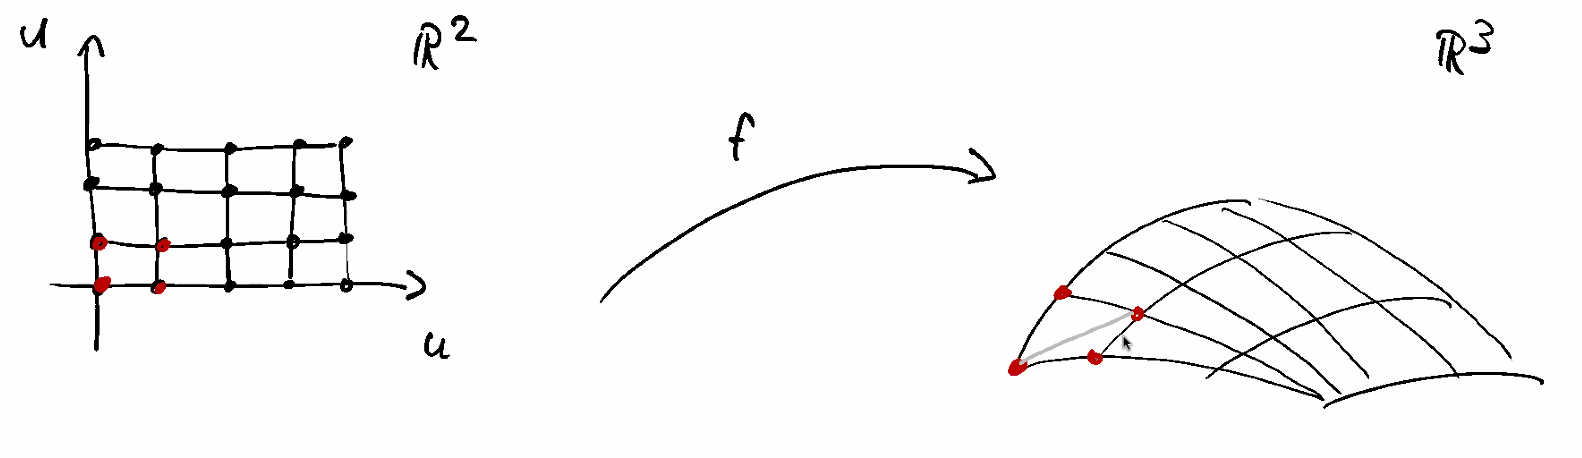

## Backface Culling

In [37]:
def TriCull (tri):

    def triangle (a, b, c):
        u = b - a
        v = c - a
        n = Cross (u, v)
        # Normalen Vektor ist nach vorne! Also sichtbar -> z Koordinate positiv
        if n [2, 0] > 0:
            p = Cat (a, b, c)
            pl.plot (p [0], p [1], color = 'black', linewidth = 0.3)

    for i in range (tri.shape [1]):
        a = tri [0:3, i] .reshape (-1, 1)
        b = tri [3:6, i] .reshape (-1, 1)
        c = tri [6:9, i] .reshape (-1, 1)
        triangle (a, b, c)

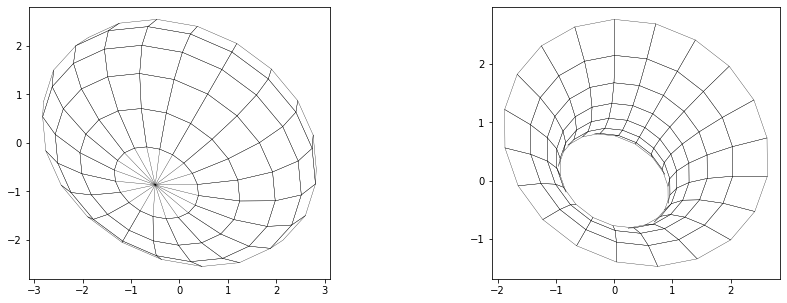

In [41]:
pl.figure (figsize = (15, 5))
pl.subplot (1, 2, 1); TriCull (ET); Iso();
#Katenoid ist nicht geschlossen, deshalb geht es nicht!
pl.subplot (1, 2, 2); TriCull (KT); Iso();

## Schattierte Dreiecke

### Licht

In [42]:
Light = Vec (-1, 1, 1)
Light = Normalized (Light)

### Dreieck zeichnen

In [43]:
def TriFlat (a, b, c, light):
    u = b - a
    v = c - a
    n = Normalized (Cross (u, v))
    s = Dot (light, n)
    m = 0.4
    c0 = m + (1 - m) * abs (s)
    p = Cat (a, b, c)
    if n [2, 0] > 0:
        c1 = (c0, c0, 0.5 * c0)
    else:
        c1 = (0, 0.6 * c0, 0.8 * c0)
    pl.fill (p [0], p [1], color = c1)

### Darstellung ohne Tiefensortierung

In [44]:
def TriFlatUnsorted (tt, light):
    for i in range (tt.shape [1]):
        a = tt [0:3, i] .reshape (-1, 1)
        b = tt [3:6, i] .reshape (-1, 1)
        c = tt [6:9, i] .reshape (-1, 1)
        TriFlat (a, b, c, light)

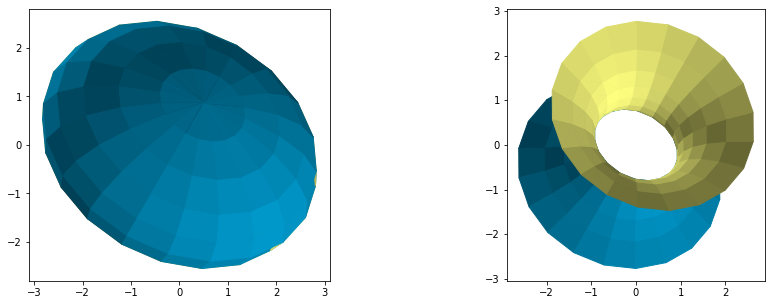

In [48]:
pl.figure (figsize = (15, 5))
#Zeigt die Rückseite!
pl.subplot (1, 2, 1); TriFlatUnsorted (ET, Light); Iso();
pl.subplot (1, 2, 2); TriFlatUnsorted (KT, Light); Iso();

### Darstellung mit Tiefensortierung (Algorithmus des Malers)

In [49]:
def TriFlatSorted (tt, light):
    m = np.maximum (tt [2, :], tt [5, :])
    m = np.maximum (m, tt [8, :])
    # Den nächsten Punkt des Dreiecks finden
    index = m.argsort()
    # Von hinten nach vorne zeichnen!
    for i in index:
        a = tt [0:3, i] .reshape (-1, 1)
        b = tt [3:6, i] .reshape (-1, 1)
        c = tt [6:9, i] .reshape (-1, 1)
        TriFlat (a, b, c, light)

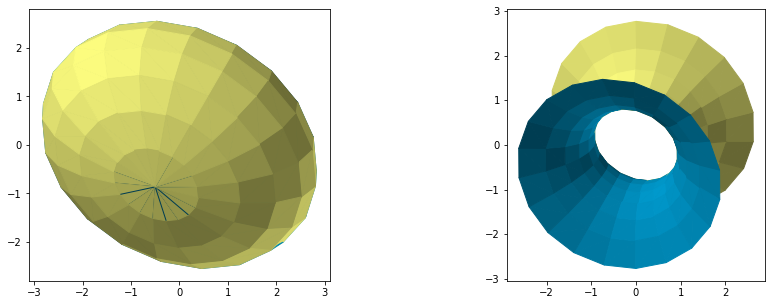

In [50]:
pl.figure (figsize = (15, 5))
pl.subplot (1, 2, 1); TriFlatSorted (ET, Light); Iso();
pl.subplot (1, 2, 2); TriFlatSorted (KT, Light); Iso();

## Ergebnis

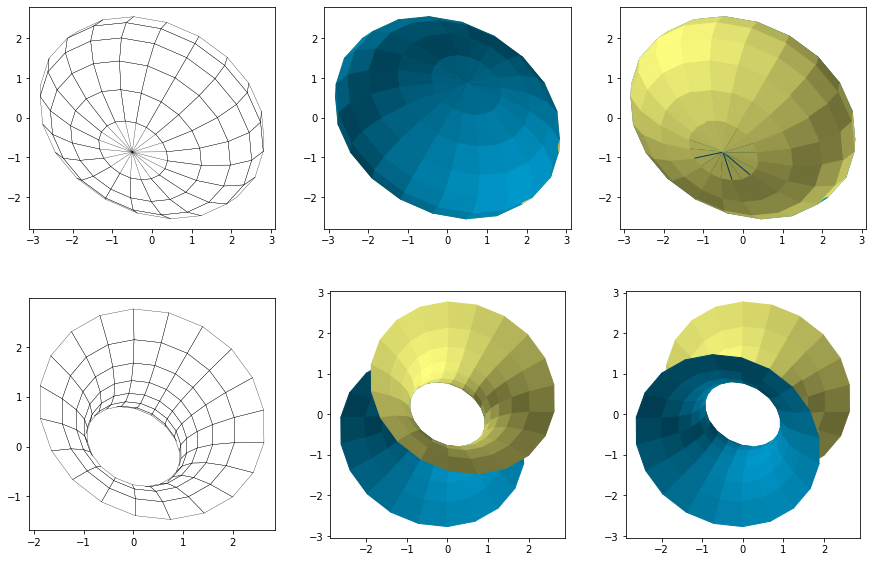

In [51]:
pl.figure (figsize = (15, 10))

pl.subplot (2, 3, 1); TriCull (ET); Iso();
pl.subplot (2, 3, 2); TriFlatUnsorted (ET, Light); Iso();
pl.subplot (2, 3, 3); TriFlatSorted (ET, Light); Iso();

pl.subplot (2, 3, 4); TriCull (KT); Iso();
pl.subplot (2, 3, 5); TriFlatUnsorted (KT, Light); Iso();
pl.subplot (2, 3, 6); TriFlatSorted (KT, Light); Iso();